# DataDoc (Research-only)

## 1. Search for MVP (research papers)

In [22]:
from gettext import install

import os
import json
import requests
import pandas as pd
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from datetime import datetime

pd.set_option("display.max_colwidth", 120)

In [15]:
# Optional but recommended: reuse one session (faster + fewer TCP handshakes)
SESSION = requests.Session()
SESSION.headers.update({"User-Agent": "DataDoc/1.0 (research project; contact: alina.skultecka@gmail.com"})

#### PubMed Central search: get PMCIDs

In [16]:
def pmc_esearch(query: str, retmax: int = 300, sort: str = "relevance",
               mindate: str = "2015", maxdate: str = "2025"):
    """
    Search the PMC database and return a list of PMC numeric IDs (as strings).

    Args:
        query (str): Search query (PMC/PubMed syntax).
        retmax (int): Max number of IDs to return.
        sort (str): 'relevance' or 'date' (and other supported sorts).
        mindate (str): Minimum publication date/year (e.g. '2015').
        maxdate (str): Maximum publication date/year (e.g. '2025').

    Returns:
        list[str]: PMC IDs.
    """
    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pmc",
        "term": query,
        "retmax": retmax,
        "retmode": "json",
        "sort": sort,
        "datetype": "pdat",
        "mindate": mindate,
        "maxdate": maxdate,
    }
    r = SESSION.get(url, params=params, timeout=60)
    r.raise_for_status()
    return r.json().get("esearchresult", {}).get("idlist", [])

#### PMC fetch details + abstracts (EFetch XML)

In [17]:
# Splits a big list into smaller pieces (batches).
def _chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

In [66]:
def pmc_esummary(pmc_ids, chunk_size: int = 200, sleep_s: float = 0.12):
    """
    Get basic metadata for PMC IDs using ESummary.
    Returns a DataFrame with: pmc_id, pmcid, title, pubdate, journal, authors
    """
    if not pmc_ids:
        return pd.DataFrame(columns=["pmc_id","pmcid","title","pubdate","journal","authors"])

    url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
    rows = []

    # Fix: chunk IDs so the URL never gets too long (prevents HTTP 414)
    pmc_ids = [str(x) for x in pmc_ids]

    for batch in _chunks(pmc_ids, chunk_size):
        params = {
            "db": "pmc",
            "id": ",".join(batch),
            "retmode": "json",
        }
        r = SESSION.get(url, params=params, timeout=60)
        r.raise_for_status()
        data = r.json()
        result = data.get("result", {})

        for pmc_id in batch:
            item = result.get(str(pmc_id), {})
            if not item:
                continue

            title = item.get("title", "")
            pubdate = item.get("pubdate", "")
            journal = item.get("fulljournalname", "") or item.get("source", "")
            authors = ", ".join(
                [a.get("name", "") for a in item.get("authors", []) if a.get("name")]
            )

            # Many PMC records also have an "articleIDs" list (sometimes includes "pmcID")
            pmcid = ""
            for aid in item.get("articleids", []):
                if aid.get("idtype") == "pmcid":
                    pmcid = aid.get("value", "")
                    break

            # Fallback: if pmcid is missing, it is usually "PMC" + pmc_id for OA items
            if not pmcid:
                pmcid = f"PMC{pmc_id}"

            rows.append({
                "pmc_id": str(pmc_id),
                "pmcid": pmcid,
                "title": title,
                "pubdate": pubdate,
                "journal": journal,
                "authors": authors,
                "url": f"https://pmc.ncbi.nlm.nih.gov/articles/{pmcid}/",
            })

        # polite rate limiting (after each batch)
        if sleep_s:
            time.sleep(sleep_s)

    # return AFTER all batches are processed
    return pd.DataFrame(rows)

#### PMC PDF link finder

In [67]:
def oa_pdf_links_from_pmcid(pmcids, chunk_size: int = 50, sleep_s: float = 0.0):
    """
    Batch OA (Open Access) service lookup for direct PDF links.
    Returns:
      - if input is a single pmcid string -> pdf_url_or_None
      - if input is list-like -> dict {pmcid: pdf_url_or_None}
    """
    url = "https://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi"
    out = {}

    # IMPORTANT: if a single "PMC123" is passed, wrap it in a list
    single = isinstance(pmcids, str)
    if single:
        pmcids = [pmcids]

    pmcids = [str(x) for x in pmcids if str(x).strip()]

    for batch in _chunks(pmcids, chunk_size):
        r = SESSION.get(url, params={"id": ",".join(batch)}, timeout=30)
        r.raise_for_status()
        root = ET.fromstring(r.text)

        # records look like <record id="PMCxxxx"> ... <link format="pdf" href="..."/>
        for rec in root.findall(".//record"):
            rid = rec.attrib.get("id", "")
            pdf = None
            for link in rec.findall(".//link"):
                if link.attrib.get("format") == "pdf":
                    pdf = link.attrib.get("href")
                    break
            if rid:
                out[rid] = pdf

        # Some IDs may have no record if not OA; set them explicitly
        for pmcid in batch:
            out.setdefault(pmcid, None)

        if sleep_s:
            time.sleep(sleep_s)

    # If user passed one pmcid, return one value (not dict)
    return out.get(pmcids[0]) if single else out

#### Run search + show results

In [68]:
query = (
'("Metabolic Syndrome"[MeSH Terms] OR "metabolic syndrome"[TIAB])'
'AND ("Alcohol Drinking"[MeSH Terms] OR alcohol[TIAB] OR "alcohol consumption"[TIAB] OR ethanol[TIAB]) '
'AND ('
'("Fatty Liver"[MeSH Terms] OR NAFLD[TIAB] OR "non-alcoholic fatty liver"[TIAB] OR fibrosis[TIAB] OR cirrhosis[TIAB] OR "liver disease"[TIAB]) '
'OR '
'("Cardiovascular Diseases"[MeSH Terms] OR CVD[TIAB] OR "myocardial infarction"[TIAB] OR stroke[TIAB] OR hypertension[TIAB])'
') '
'AND (Sweden[TIAB] OR Swedish[TIAB] OR Scandinavia[TIAB] OR Scandinavian[TIAB] OR Nordic[TIAB])'
)
pmc_ids = pmc_esearch(query, retmax=300)

df = pmc_esummary(pmc_ids)

# Add PDF links (OA only)
df["pdf_url"] = df["pmcid"].apply(oa_pdf_links_from_pmcid)

# Keep only rows that really have a PDF
df_with_pdf = df[df["pdf_url"].notna() & (df["pdf_url"] != "")].reset_index(drop=True)

df_with_pdf

,pmc_id,pmcid,title,pubdate,journal,authors,url,pdf_url
0,8514420,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,2021 Sep 17,JHEP Reports,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/35/cd/main.PMC8514420.pdf
1,11299976,PMC11299976,EASL-EASD-EASO Clinical Practice Guidelines on the Management of Metabolic Dysfunction-Associated Steatotic Liver Di...,2024 Jun 7,Obesity Facts,"European Association for the Study of the Liver (EASL)*, European Association for the Study of Diabetes (EASD), Euro...",https://pmc.ncbi.nlm.nih.gov/articles/PMC11299976/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/ca/74/ofa-2024-0017-0004-539371.PMC11299976.pdf
2,6796246,PMC6796246,UEG Week 2018 Poster Presentations,2018 Oct 21,United European Gastroenterology Journal,,https://pmc.ncbi.nlm.nih.gov/articles/PMC6796246/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/c1/97/10.1177_2050640618792819.PMC6796246.pdf
3,10588738,PMC10588738,TASL Practice Guidance on the Clinical Assessment and Management of Patients with Nonalcoholic Fatty Liver Disease,2023 Mar 15,Hepatology Forum,"Yilmaz Y, Zeybel M, Adali G, Cosar AM, Sertesen E, Gokcan H, Bahcecioglu HI, Sahin M, Tulunay C, Ergun I, Turan I, I...",https://pmc.ncbi.nlm.nih.gov/articles/PMC10588738/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/4d/4f/hf-4-s1.PMC10588738.pdf
4,8771615,PMC8771615,Non-alcoholic fatty liver disease and hepatocellular carcinoma: Clinical challenges of an intriguing link,2022 Jan 21,World Journal of Gastroenterology,"Chrysavgis L, Giannakodimos I, Diamantopoulou P, Cholongitas E",https://pmc.ncbi.nlm.nih.gov/articles/PMC8771615/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/12/03/WJG-28-310.PMC8771615.pdf
...,...,...,...,...,...,...,...,...
101,12341116,PMC12341116,Prognostic value of FIB-4 and NFS for cardiovascular events in patients with and without NAFLD,2025 Aug 12,BMC Public Health,"Zhang J, Li L, Lin L, Wu Y, Hu L, Feng Z, Zhang D, Fu T, Zhao H, Yin X, Yu P, Gu X, Liu X, Wang W",https://pmc.ncbi.nlm.nih.gov/articles/PMC12341116/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/68/16/12889_2025_Article_23883.PMC12341116.pdf
102,5741551,PMC5741551,Non-Alcoholic Fatty Liver Disease: The Emerging Burden in Cardiometabolic and Renal Diseases,2017 Nov 17,Diabetes & Metabolism Journal,"Han E, Lee YH",https://pmc.ncbi.nlm.nih.gov/articles/PMC5741551/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/d7/8d/dmj-41-430.PMC5741551.pdf
103,9280503,PMC9280503,Clinical Practice Guidelines for Liver Transplantation in Saudi Arabia,2021 Sep,Saudi Medical Journal,"Abaalkhail FA, Al Sebayel MI, Shagrani MA, O’Hali WA, Almasri NM, Alalwan AA, Alghamdi MY, Al-Bahili H, AlQahtani MS...",https://pmc.ncbi.nlm.nih.gov/articles/PMC9280503/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/cd/bc/SaudiMedJ-42-9-927.PMC9280503.pdf
104,8884083,PMC8884083,Tolerable upper intake level for dietary sugars,2022 Feb 28,EFSA Journal,"EFSA Panel on Nutrition, Novel Foods and Food Allergens (NDA), Turck D, Bohn T, Castenmiller J, de Henauw S, Hirsch‐...",https://pmc.ncbi.nlm.nih.gov/articles/PMC8884083/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/1b/a0/EFS2-20-e07074.PMC8884083.pdf


#### Save results to JSON


In [69]:
out_path = "results.json"
df_with_pdf.to_json(out_path, orient="records", force_ascii=False, indent=2)
print("Saved to:", out_path)


Saved to: results.json


## 2. Download research papers

#### Imports + load your results

- Loads results.json into a pandas DataFrame (df_final)
- head() just shows the first rows (preview)

In [70]:
import os
import re
import requests
import pandas as pd

df_final = pd.read_json("results.json")
df_final.head()

,pmc_id,pmcid,title,pubdate,journal,authors,url,pdf_url
0,8514420,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,2021 Sep 17,JHEP Reports,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/35/cd/main.PMC8514420.pdf
1,11299976,PMC11299976,EASL-EASD-EASO Clinical Practice Guidelines on the Management of Metabolic Dysfunction-Associated Steatotic Liver Di...,2024 Jun 7,Obesity Facts,"European Association for the Study of the Liver (EASL)*, European Association for the Study of Diabetes (EASD), Euro...",https://pmc.ncbi.nlm.nih.gov/articles/PMC11299976/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/ca/74/ofa-2024-0017-0004-539371.PMC11299976.pdf
2,6796246,PMC6796246,UEG Week 2018 Poster Presentations,2018 Oct 21,United European Gastroenterology Journal,,https://pmc.ncbi.nlm.nih.gov/articles/PMC6796246/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/c1/97/10.1177_2050640618792819.PMC6796246.pdf
3,10588738,PMC10588738,TASL Practice Guidance on the Clinical Assessment and Management of Patients with Nonalcoholic Fatty Liver Disease,2023 Mar 15,Hepatology Forum,"Yilmaz Y, Zeybel M, Adali G, Cosar AM, Sertesen E, Gokcan H, Bahcecioglu HI, Sahin M, Tulunay C, Ergun I, Turan I, I...",https://pmc.ncbi.nlm.nih.gov/articles/PMC10588738/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/4d/4f/hf-4-s1.PMC10588738.pdf
4,8771615,PMC8771615,Non-alcoholic fatty liver disease and hepatocellular carcinoma: Clinical challenges of an intriguing link,2022 Jan 21,World Journal of Gastroenterology,"Chrysavgis L, Giannakodimos I, Diamantopoulou P, Cholongitas E",https://pmc.ncbi.nlm.nih.gov/articles/PMC8771615/,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/12/03/WJG-28-310.PMC8771615.pdf


#### Takes a text (usually pmcid - title) and cleans it so Windows accepts it as a filename

- Helper: make a Windows-safe filename
- Purpose: turn something like
PMC123456 - A Study: alcohol/NAFLD?
into a filename Windows allows.

In [71]:
def _safe_filename(text: str, max_len: int = 140) -> str:
    """Make a Windows-safe filename."""
    if text is None:
        return "paper"
    text = str(text).strip()
    text = re.sub(r'[\\/:*?"<>|]+', "_", text)   # Windows illegal chars
    text = re.sub(r"\s+", " ", text)
    return text[:max_len].strip()

#### Main function: download PDFs for all rows in my DataFrame

In [72]:
def download_pdfs(df: pd.DataFrame, download_folder: str = "files",
                  url_col: str = "pdf_url", id_col: str = "pmcid",
                  title_col: str = "title"):
    """
    Download PDFs from URLs in a DataFrame and save them to a folder.
    Adds a new column 'pdf_file_name' with the saved file path (or None if failed).

    Args:
        df (pd.DataFrame): Must contain a column with PDF URLs (default: 'pdf_url').
        download_folder (str): Folder where PDFs will be saved.
        url_col (str): Name of the column containing PDF URLs.
        id_col (str): Column to use for file naming (e.g. 'pmcid' or 'paper_id').
        title_col (str): Column to use for file naming (optional).

    Returns:
        pd.DataFrame: Same df with new column 'pdf_file_name'.
    """

    # Check that the DataFrame has the pdf column
    if url_col not in df.columns:
        raise ValueError(f"DataFrame must contain column '{url_col}'")

    os.makedirs(download_folder, exist_ok=True)

    pdf_file_names = []
    headers = {"User-Agent": "DataDoc/1.0 (research project)"}

    for _, row in df.iterrows():
        pdf_link = row.get(url_col)
        pdf_link = str(pdf_link).strip()
        if pdf_link.startswith("ftp://ftp.ncbi.nlm.nih.gov/"):
            pdf_link = pdf_link.replace("ftp://ftp.ncbi.nlm.nih.gov/", "https://ftp.ncbi.nlm.nih.gov/")

        # Skip rows without a link
        if pd.isna(pdf_link) or not str(pdf_link).strip():
            pdf_file_names.append(None)
            continue

        # Build a nice filename
        paper_id = row.get(id_col) or row.get("paper_id") or row.get("pmid") or "paper"
        title = row.get(title_col) or ""
        base = _safe_filename(f"{paper_id} - {title}" if title else str(paper_id))
        file_name = os.path.join(download_folder, base + ".pdf")

        try:
            # Download (stream so large PDFs don't eat RAM)
            r = requests.get(str(pdf_link), headers=headers, stream=True, timeout=60, allow_redirects=True)
            r.raise_for_status()

            # Optional check: confirm it's a PDF
            content_type = (r.headers.get("Content-Type") or "").lower()
            if "pdf" not in content_type:
                pdf_file_names.append(None)
                print(f"Skipped (not PDF content-type): {pdf_link}")
                continue

            with open(file_name, "wb") as f:
                for chunk in r.iter_content(chunk_size=1024 * 64):
                    if chunk:
                        f.write(chunk)

            pdf_file_names.append(file_name)
            print(f"Downloaded: {file_name}")

        except requests.exceptions.RequestException as e:
            print(f"Failed: {pdf_link} -> {e}")
            pdf_file_names.append(None)

    df = df.copy()
    df["pdf_file_name"] = pdf_file_names
    return df


In [73]:
df_final = download_pdfs(df_final, download_folder="data", url_col="pdf_url", id_col="pmcid", title_col="title")
df_final[["pmcid", "title", "pdf_url", "pdf_file_name"]].head()

Downloaded: data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline.pdf
Downloaded: data\PMC11299976 - EASL-EASD-EASO Clinical Practice Guidelines on the Management of Metabolic Dysfunction-Associated Steatotic Liver Disease (MAS.pdf
Downloaded: data\PMC6796246 - UEG Week 2018 Poster Presentations.pdf
Downloaded: data\PMC10588738 - TASL Practice Guidance on the Clinical Assessment and Management of Patients with Nonalcoholic Fatty Liver Disease.pdf
Downloaded: data\PMC8771615 - Non-alcoholic fatty liver disease and hepatocellular carcinoma_ Clinical challenges of an intriguing link.pdf
Downloaded: data\PMC9123074 - Non-alcoholic fatty liver disease in adults 2021_ A clinical practice guideline of the Italian Association for the Study of the.pdf
Downloaded: data\PMC10835535 - Portal hypertension in patients with nonalcoholic fatty liver disease_ Current knowledge and challenges.pdf
Downloaded: data\PMC10954435 - Interactions between the metabolic syndrome and alcohol co

,pmcid,title,pdf_url,pdf_file_name
0,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/35/cd/main.PMC8514420.pdf,data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline.pdf
1,PMC11299976,EASL-EASD-EASO Clinical Practice Guidelines on the Management of Metabolic Dysfunction-Associated Steatotic Liver Di...,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/ca/74/ofa-2024-0017-0004-539371.PMC11299976.pdf,data\PMC11299976 - EASL-EASD-EASO Clinical Practice Guidelines on the Management of Metabolic Dysfunction-Associated...
2,PMC6796246,UEG Week 2018 Poster Presentations,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/c1/97/10.1177_2050640618792819.PMC6796246.pdf,data\PMC6796246 - UEG Week 2018 Poster Presentations.pdf
3,PMC10588738,TASL Practice Guidance on the Clinical Assessment and Management of Patients with Nonalcoholic Fatty Liver Disease,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/4d/4f/hf-4-s1.PMC10588738.pdf,data\PMC10588738 - TASL Practice Guidance on the Clinical Assessment and Management of Patients with Nonalcoholic Fa...
4,PMC8771615,Non-alcoholic fatty liver disease and hepatocellular carcinoma: Clinical challenges of an intriguing link,ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_pdf/12/03/WJG-28-310.PMC8771615.pdf,data\PMC8771615 - Non-alcoholic fatty liver disease and hepatocellular carcinoma_ Clinical challenges of an intrigui...


Saving metadata about our papers to be able to:
- resume work tomorrow without re-downloading,
- debugging (see which PDFs downloaded/failed),
- reproducibility (a frozen input to the chunking step).

In [74]:
df_final.to_json("data/results_with_files.json", orient="records", indent=2)
print("Saved:", os.path.abspath("data/results_with_files.json"))

Saved: C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\results_with_files.json


## 3. Loading and Splitting PDF Files into Chunks, Expanding the DataFrame

Load_and_chunk_pdf works on one PDF file and returns a list of text chunks
- Takes a path to one PDF.
- Loads the PDF using LangChain’s PyPDFLoader.
- Splits the PDF text into chunks using RecursiveCharacterTextSplitter.
- docs becomes a list of LangChain Document objects.

In [61]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

def load_and_chunk_pdf(pdf_file_name: str, chunk_size: int = 512, chunk_overlap: int = 64):
    """
    Loads a PDF file and splits its content into chunks.

    Args:
        pdf_file_name (str): Path to the PDF file.
        chunk_size (int): Max characters per chunk.
        chunk_overlap (int): Overlap between chunks to preserve context.

    Returns:
        list: List of LangChain Document chunks.
    """
    print(f"Loading and splitting into chunks: {pdf_file_name}")

    loader = PyPDFLoader(pdf_file_name)
    docs = loader.load()

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = splitter.split_documents(docs)
    return chunks

Expand_df works on the whole dataframe of many papers, calls load_and_chunk_pdf for each PDF, and turns all those chunks into a new dataframe where each chunk becomes its own row with metadata (pmcid/title/page/links to neighbor chunks).

In [75]:
def expand_df(df: pd.DataFrame,
              id_col: str = "pmcid",
              fallback_id_col: str = "paper_id",
              pdf_col: str = "pdf_file_name"):
    """
    Expand each paper row into many rows (one per text chunk from the PDF).

    Requires:
      - a PDF file path column (default: 'pdf_file_name')
      - an ID column for stable chunk ids (default: 'pmcid'; falls back to 'paper_id')
      - load_and_chunk_pdf(pdf_path) must already exist

    Output columns:
      - id:        unique chunk id like "PMC1234567#12"
      - title, authors, year, journal, abstract, url: copied from the paper row (if present)
      - chunk:     the chunk text
      - prechunk_id / postchunk_id: links to adjacent chunks
      - source_file: original PDF path
    """
    expanded_rows = []

    for _, row in df.iterrows():
        pdf_path = row.get(pdf_col)

        if pd.isna(pdf_path) or not str(pdf_path).strip():
            continue

        # normalize path
        pdf_path = os.path.normpath(str(pdf_path).strip())

        # make it absolute (based on current notebook folder)
        pdf_path = os.path.abspath(pdf_path)

        # verify it exists
        if not os.path.isfile(pdf_path):
            print(f"Missing file on disk: {pdf_path}")
            continue

        # Choose a stable id for chunk naming (PMC8514420#0, PMC8514420#1)
        doc_id = row.get(id_col)
        if pd.isna(doc_id) or not str(doc_id).strip():
            doc_id = row.get(fallback_id_col)
        doc_id = str(doc_id).strip() if doc_id else "paper"

        try:
            chunks = load_and_chunk_pdf(pdf_path)
        except Exception as e:
            print(f"Error processing file {pdf_path}: {e}")
            continue

        for i, chunk in enumerate(chunks):
            pre_id = f"{doc_id}#{i-1}" if i > 0 else ""
            post_id = f"{doc_id}#{i+1}" if i < len(chunks) - 1 else ""

            expanded_rows.append({
                "id": f"{doc_id}#{i}",
                "doc_id": doc_id,                 # helpful for grouping
                "paper_id": row.get("paper_id", None),
                "pmcid": row.get("pmcid", None),
                "title": row.get("title", None),
                "authors": row.get("authors", None),
                "year": row.get("year", None),
                "journal": row.get("journal", None),
                "abstract": row.get("abstract", None),
                "url": row.get("url", None),
                "chunk": chunk.page_content,
                "page": chunk.metadata.get("page", None),
                "prechunk_id": pre_id,
                "postchunk_id": post_id,
                "source_file": pdf_path,
            })

    return pd.DataFrame(expanded_rows)

In [76]:
df_final = pd.read_json("data/results_with_files.json")

df_chunks = expand_df(df_final, pdf_col="pdf_file_name")

print("Total chunks:", len(df_chunks))
df_chunks.head()

Loading and splitting into chunks: C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline.pdf
Loading and splitting into chunks: C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC11299976 - EASL-EASD-EASO Clinical Practice Guidelines on the Management of Metabolic Dysfunction-Associated Steatotic Liver Disease (MAS.pdf
Loading and splitting into chunks: C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC6796246 - UEG Week 2018 Poster Presentations.pdf
Loading and splitting into chunks: C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC10588738 - TASL Practice Guidance on the Clinical Assessment and Management of Patients with Nonalcoholic Fatty Liver Disease.pdf
Loading and splitting into chunks: C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8771615 - Non-alcoholic fatty liver disease and hepatocellular carcinoma_ Clinical challenges of an intriguing link.pdf
Loading and splitting into chunks: C:\Users\grigo\Deskt

,id,doc_id,paper_id,pmcid,title,authors,year,journal,abstract,url,chunk,page,prechunk_id,postchunk_id,source_file
0,PMC8514420#0,PMC8514420,None,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",None,JHEP Reports,None,https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,"Non-alcoholic fatty liver disease: A patient guideline\nSven M. Francque,1,2,3,4,* Giulio Marchesini,5,6 Achim Kautz...",0,,PMC8514420#1,C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline...
1,PMC8514420#1,PMC8514420,None,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",None,JHEP Reports,None,https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,Summary\nThis patient guideline is intended for all patients at risk of or living with non-alcoholic fatty liver\ndi...,0,PMC8514420#0,PMC8514420#2,C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline...
2,PMC8514420#2,PMC8514420,None,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",None,JHEP Reports,None,https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,providers. It is important for patients to develop a full understanding of NAFLD in order to enable\nthem to take an...,0,PMC8514420#1,PMC8514420#3,C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline...
3,PMC8514420#3,PMC8514420,None,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",None,JHEP Reports,None,https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,intended to support patients in making informed decisions.\n© 2021 The Authors. Published by Elsevier B.V. on behalf...,0,PMC8514420#2,PMC8514420#4,C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline...
4,PMC8514420#4,PMC8514420,None,PMC8514420,Non-alcoholic fatty liver disease: A patient guideline,"Francque SM, Marchesini G, Kautz A, Walmsley M, Dorner R, Lazarus JV, Zelber-Sagi S, Hallsworth K, Busetto L, Frühbe...",None,JHEP Reports,None,https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/,(NAFLD). NAFLD is a serious condition. It is\nimportant that you develop a full understanding of\nit. This has sever...,0,PMC8514420#3,PMC8514420#5,C:\Users\grigo\Desktop\Python_Tasks\DataDoc\data\PMC8514420 - Non-alcoholic fatty liver disease_ A patient guideline...


## 4.Building a Knowledge Base for the RAG System Using Embedding

In [89]:
from dotenv import load_dotenv, find_dotenv

# Load the API keys from .env
load_dotenv(find_dotenv(), override=True)

True

In [106]:
import os
from getpass import getpass

from semantic_router.encoders import OpenAIEncoder

# Check if 'OPENAI_API_KEY' is set; prompt if not
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') or getpass('OpenAI API key: ')

# Initialize the OpenAIEncoder with a specific model, does the embedding
encoder = OpenAIEncoder(name='text-embedding-3-small')

#### Creating a Pinecone Index

In [107]:
import os
from getpass import getpass

from pinecone.grpc import PineconeGRPC as Pinecone
from pinecone import ServerlessSpec  # keep this if you create indexes elsewhere

# Get API key
api_key = os.getenv("PINECONE_API_KEY") or getpass("Pinecone API key: ")

# Initialize Pinecone (gRPC data-plane client)
pc = Pinecone(api_key=api_key)

# If you still need spec for CREATE index calls, keep it:
spec = ServerlessSpec(cloud="aws", region="us-east-1")


In [108]:
import time

# Define the name of the index
index_name = 'langgraph-research-agent'
dims = 1536  # <- must match your embedding vector length

pc = Pinecone(api_key=api_key)

# List index names (helper exists in the SDK docs)
existing = pc.list_indexes().names()  # if these errors, see note below

if index_name not in existing:
    pc.create_index(
        name=index_name,
        dimension=dims,
        metric="cosine",
        spec=spec
    )
    # Wait until ready
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)

# Connect to the index
index_desc = pc.describe_index(index_name)
index = pc.Index(host=index_desc.host)

In [109]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'__default__': {'vector_count': 0}},
 'total_vector_count': 0}

## 5. Populating the Knowledge Base and Uploading it to Pinecone

Sanitize metadata strings before upsert, because one of your metadata strings (or a “chunk” you stored in metadata) contains fancy Unicode punctuation like:

- en-dash – / em-dash —
- smart quotes “ ” ‘ ’
- ellipsis …

In [112]:
import unicodedata
import pandas as pd

LIGATURES = {
    "\ufb00": "ff",
    "\ufb01": "fi",
    "\ufb02": "fl",
    "\ufb03": "ffi",
    "\ufb04": "ffl",
    "\ufb05": "ft",
    "\ufb06": "st",
}

# Characters that commonly break latin-1 encoding or cause weird request bodies
PUNCT_MAP = {
    "\u2010": "-",  # hyphen
    "\u2011": "-",  # non-breaking hyphen
    "\u2012": "-",  # figure dash
    "\u2013": "-",  # en-dash  ← your error
    "\u2014": "-",  # em-dash
    "\u2212": "-",  # minus sign
    "\u2018": "'",  # left single quote
    "\u2019": "'",  # right single quote
    "\u201B": "'",  # single high-reversed-9 quote
    "\u201C": '"',  # left double quote
    "\u201D": '"',  # right double quote
    "\u201E": '"',  # double low-9 quote
    "\u00A0": " ",  # non-breaking space
    "\u2026": "...",# ellipsis
}

def normalize_text(s: object, *, latin1_safe: bool = True, max_len: int | None = None) -> str:
    """
    Normalize text for embeddings + Pinecone metadata.
    - Fix ligatures
    - Convert problematic punctuation to ASCII
    - Unicode normalize (NFKC)
    - Remove control characters (except \\n \\t)
    - Optionally force latin-1 safety (drop characters not representable)
    """
    if s is None:
        return ""

    s = str(s)

    # 1) Replace ligatures first (from PDFs)
    for k, v in LIGATURES.items():
        s = s.replace(k, v)

    # 2) Replace punctuation that commonly causes encoding issues
    # (do before NFKC so it doesn't re-introduce weird forms)
    for k, v in PUNCT_MAP.items():
        s = s.replace(k, v)

    # 3) Normalize unicode to a standard form
    s = unicodedata.normalize("NFKC", s)

    # 4) Remove control characters (keep \n and \t)
    s = "".join(ch for ch in s if ch in ("\n", "\t") or ord(ch) >= 32)

    # 5) If you want to guarantee no latin-1 crashes anywhere:
    if latin1_safe:
        # keep Swedish chars (åäö) fine; drop emoji/rare symbols that can break clients
        s = s.encode("latin-1", errors="ignore").decode("latin-1")

    # 6) Optional truncate (useful for metadata previews)
    if max_len is not None and len(s) > max_len:
        s = s[:max_len]

    return s

In [113]:
def clean_metadata(d: dict) -> dict:
    """
    Pinecone metadata values must be: string, number, boolean, or list of strings.
    Removes None/NaN and normalizes strings so upsert won't fail.
    """
    clean = {}
    for k, v in d.items():
        if v is None:
            continue

        # skip NaN
        try:
            if pd.isna(v):
                continue
        except Exception:
            pass

        if isinstance(v, str):
            clean[k] = normalize_text(v, latin1_safe=True)
        elif isinstance(v, list):
            # keep only strings, normalized; ignore None/non-string values
            clean[k] = [normalize_text(x, latin1_safe=True) for x in v if isinstance(x, str)]
        else:
            # numbers/bools OK
            clean[k] = v

    return clean

In [114]:
from tqdm.auto import tqdm
import numpy as np

data = df_chunks.reset_index(drop=True)
batch_size = 64

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)
    batch = data.iloc[i:i_end].to_dict(orient="records")

    ids = [str(r["id"]) for r in batch]

    # normalize chunk text before embedding
    texts = [normalize_text(r.get("chunk") or "", latin1_safe=False) for r in batch]
    # ^ latin1_safe=False here is fine because embeddings can handle unicode;
    # we only need latin1_safe=True for metadata going through Pinecone client.

    embeds = encoder(texts)

    if isinstance(embeds, np.ndarray):
        embeds = embeds.tolist()

    if len(embeds) != len(ids):
        raise ValueError(f"Embedding count mismatch: {len(embeds)} vs {len(ids)}")
    if len(embeds) > 0 and len(embeds[0]) != dims:
        raise ValueError(f"Embedding dim mismatch: got {len(embeds[0])}, expected {dims}")

    metadata = []
    for r, txt in zip(batch, texts):
        md = {
            "doc_id": r.get("doc_id"),
            "pmcid": r.get("pmcid"),
            "paper_id": r.get("paper_id"),
            "title": r.get("title"),
            "year": r.get("year"),
            "journal": r.get("journal"),
            "url": r.get("url"),
            "page": r.get("page"),
            # keep preview short + latin1-safe
            "chunk_preview": normalize_text(txt, latin1_safe=True, max_len=300),
        }
        metadata.append(clean_metadata(md))

    vectors = [{"id": ids[j], "values": embeds[j], "metadata": metadata[j]} for j in range(len(ids))]

    index.upsert(vectors=vectors, namespace="pmc")

index.describe_index_stats()

  0%|          | 0/826 [00:00<?, ?it/s]

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'pmc': {'vector_count': 52829}},
 'total_vector_count': 52829}

## 6. Fetch a PMC article page

It takes information directly from NCBI / PubMed Central (PMC) over the internet.
- “Search/fetch from PMC servers” → parse XML → return abstract.

In [143]:
from langchain_core.tools import tool
import requests
import xml.etree.ElementTree as ET
import re

UA = {"User-Agent": "DataDoc/1.0 (research project)"}

def _clean_ws(s: str) -> str:
    # collapse repeated whitespace but keep newlines
    s = re.sub(r"[ \t\r\f\v]+", " ", s)
    s = re.sub(r"\n{3,}", "\n\n", s)
    return s.strip()

@tool("fetch_pmc_xml")
def fetch_pmc_xml(pmcid: str) -> str:
    """
    Fetch the FULL abstract from PMC using NCBI E-utilities (EFetch) XML.
    Returns a plain string (abstract) or an error message if not found.
    """
    pmcid = pmcid.strip()
    if pmcid.upper().startswith("PMC"):
        pmc_numeric = pmcid[3:]
    else:
        pmc_numeric = pmcid

    efetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {"db": "pmc", "id": pmc_numeric, "retmode": "xml"}

    res = requests.get(efetch_url, params=params, headers=UA, timeout=30)
    res.raise_for_status()
    root = ET.fromstring(res.text)

    # 1) Try common JATS locations for abstracts
    abstract_nodes = []
    abstract_nodes.extend(root.findall(".//abstract"))
    abstract_nodes.extend(root.findall(".//trans-abstract"))  # sometimes translated abstracts

    parts: list[str] = []

    for abs_node in abstract_nodes:
        # Prefer <p> sections if they exist
        ps = abs_node.findall(".//p")
        if ps:
            for p in ps:
                txt = "".join(p.itertext())
                txt = _clean_ws(txt)
                if txt:
                    parts.append(txt)
        else:
            # No <p> tags: take all text under <abstract>
            txt = "".join(abs_node.itertext())
            txt = _clean_ws(txt)
            if txt:
                parts.append(txt)

    # Remove duplicates while preserving order (sometimes abstract repeats)
    seen = set()
    uniq_parts = []
    for t in parts:
        if t not in seen:
            seen.add(t)
            uniq_parts.append(t)

    abstract = "\n\n".join(uniq_parts).strip()
    return abstract if abstract else "Abstract not found in PMC XML."


In [146]:
print(fetch_pmc_xml.invoke({"pmcid": "PMC11231708"}))

Deteriorated sinusitis and increased adiposity relative to muscle mass may affect quality of life in patients with asthma. However, whether these effects are observed regardless of intrapulmonary pathology is unknown.

We evaluated the correlation of the cross-sectional ratio of abdominal visceral fat (VF) to erector spinae muscle (ESM) and sinus findings based on Lund-Mackey scoring system (LMS) on computed tomography (CT) with the impaired score of the Asthma Quality of Life Questionnaire (AQLQ), regardless of airway and parenchymal disease, in patients with asthma.

We recruited participants from the Hokkaido-based severe asthma cohort who had completed AQLQ and CT examination at the entry. The participants were divided into high (highest) and low (other quartiles) groups on the bases of the extrapulmonary indices. Multivariate analysis examined the association of VF/ESM for the adiposity-to-muscle ratio and LMS with AQLQ after adjusting for the airway fractal dimension for airway i

## 7. Integrating Google SerpAPI for Web Search

In [147]:
from dotenv import load_dotenv, find_dotenv

# Load the API keys from .env
load_dotenv(find_dotenv(), override=True)

True

In [148]:
from langchain_core.tools import tool
from serpapi import GoogleSearch
import os
from getpass import getpass

SERPAPI_KEY = os.getenv("SERPAPI_KEY") or getpass("SerpAPI key: ")

serpapi_params = {
    "engine": "google",
    "api_key": SERPAPI_KEY,
}

@tool("web_search")
def web_search(query: str) -> str:
    """
    Finds general information using a Google search via SerpAPI.

    Args:
        query (str): The search query string.

    Returns:
        str: Top results formatted as:
             Title
             Snippet
             Link
             ---
             ...
    """
    search = GoogleSearch({
        **serpapi_params,
        "q": query,
        "num": 5
    })

    results = search.get_dict().get("organic_results", [])

    if not results:
        return "No results found."

    formatted_results = "\n---\n".join(
        "\n".join([
            r.get("title", "").strip(),
            r.get("snippet", "").strip(),
            r.get("link", "").strip(),
        ]).strip()
        for r in results
    )

    return formatted_results

In [149]:
print(web_search.invoke({"query": "metabolic syndrome alcohol Sweden site:pmc.ncbi.nlm.nih.gov"}))

Comparison of associations between alcohol consumption ...
Adjusted for age and sex, medium-high alcohol consumption was associated with lower odds of MetS compared to low consumption, while no difference was observed ...
https://pmc.ncbi.nlm.nih.gov/articles/PMC11231701/
---
Consumption of Alcoholic Beverages and the Prevalence of ...
One prospective study found a linear increase in metabolic syndrome risk with an increase in alcohol consumption [8].
https://pmc.ncbi.nlm.nih.gov/articles/PMC6893759/
---
Interactions between the metabolic syndrome and alcohol ...
People with an alcohol use disorder (AUD) have a higher risk of T2DM compared with people in the general population. ... This is most likely due to the ...
https://pmc.ncbi.nlm.nih.gov/articles/PMC10954435/
---
Alcohol use disorder and alcohol-related mortality after ...
Increased sensitivity to alcohol due to an altered alcohol metabolism has been observed, especially after gastric bypass (GBP) surgery.
https://pmc.ncbi.nlm.n

## 8. Creating RAG Tools for Retrieval-Augmented Generation (RAG)

In [155]:
from langchain_core.tools import tool
import re
from typing import Any

In [156]:
# Helpers
def normalize_pmcid(pmcid: str) -> str:
    """Return canonical PMCID like 'PMC11231701'."""
    pmcid = (pmcid or "").strip()
    if not pmcid:
        return ""
    if not pmcid.upper().startswith("PMC"):
        pmcid = "PMC" + pmcid
    return "PMC" + pmcid[3:]  # normalize casing

def format_rag_contexts(matches: list[dict[str, Any]]) -> str:
    """
    Format Pinecone matches into readable context for LLM/user.
    Uses safe fallbacks for common metadata field names.
    """
    if not matches:
        return "No matches found."

    blocks: list[str] = []
    for i, m in enumerate(matches, start=1):
        md = m.get("metadata") or {}
        score = m.get("score", "")

        # Common metadata keys (use fallbacks because schemas differ)
        title = md.get("title", "")
        pmcid = md.get("pmcid", "")
        year = md.get("year", "") or md.get("pub_year", "") or md.get("pubdate", "")
        journal = md.get("journal", "")
        page = md.get("page", "") or md.get("page_number", "")
        url = md.get("url", "") or md.get("article_url", "") or md.get("pdf_url", "")
        chunk = md.get("chunk_preview") or md.get("chunk") or md.get("text") or ""

        # Make chunk readable
        chunk = " ".join(str(chunk).split())

        lines = [
            f"[Match {i}] Score: {score}",
            f"Title: {title}",
            f"PMCID: {pmcid}",
        ]
        if year:    lines.append(f"Year/PubDate: {year}")
        if journal: lines.append(f"Journal: {journal}")
        if page != "": lines.append(f"Page: {page}")
        if url:     lines.append(f"URL: {url}")
        if chunk:   lines.append(f"Chunk: {chunk}")

        blocks.append("\n".join(lines).strip())

    return "\n---\n".join(blocks)

## `rag_search` (global search)

Use this when the user **hasn’t chosen an article** yet.

- Searches **all chunks in Pinecone** (all papers you indexed)
- Best for questions like:
  - “Find papers about metabolic syndrome and alcohol in Sweden”
  - “What does research say about NAFLD and alcohol?”
- It helps you **discover** which paper(s) are relevant.

## `rag_search_filter_pmc` (search inside one specific paper)

Use this when the user **already knows the paper** (or you already picked it).

- Searches **only within one PMCID** using `filter={"pmcid": ...}`
- Best for questions like:
  - “In PMC11231701, what did they conclude?”
  - “What are the methods in this paper?”
- It prevents the model from mixing info from other papers and keeps answers **consistent**.

## Why filtering matters (real RAG reason)

If you ask: *“What’s the conclusion?”* and you use global `rag_search`,
Pinecone might return chunks from **different papers** that all mention “conclusion”.
Then the LLM may combine them into one answer → **wrong or mixed**.

With `rag_search_filter_pmc`, you guarantee:
- all chunks come from the same article
- answers match that one paper
- easier citations (“this is from PMC11231701”)

## Typical best workflow in the app

1. User asks a topic → call `rag_search(query)` to find relevant papers
2. Show top candidates (pmcid / title)
3. User picks one (or your agent picks the best)
4. All follow-up questions use `rag_search_filter_pmc(query, pmcid)`

In [ ]:
# Tools
@tool("rag_search")
def rag_search(query: str) -> str:
    """
    Search ALL PMC chunks in Pinecone (no PMCID filter).
    """
    query = (query or "").strip()
    if not query:
        return "Please provide a non-empty query."

    # encoder returns list of vectors; take first
    xq = encoder([query])[0]

    xc = index.query(
        vector=xq,
        top_k=6,
        include_metadata=True,
        namespace="pmc"
    )

    return format_rag_contexts(xc.get("matches", []))


@tool("rag_search_filter_pmc")
def rag_search_filter_pmc(query: str, pmcid: str) -> str:
    """
    Search Pinecone but restrict results to ONE PMC article (PMCID filter).
    """
    query = (query or "").strip()
    if not query:
        return "Please provide a non-empty query."

    pmcid_norm = normalize_pmcid(pmcid)
    if not pmcid_norm:
        return "Please provide a PMCID like 'PMC11231701'."

    xq = encoder([query])[0]

    xc = index.query(
        vector=xq,
        top_k=6,
        include_metadata=True,
        namespace="pmc",
        filter={"pmcid": pmcid_norm}
    )

    return format_rag_contexts(xc.get("matches", []))

In [153]:
print(rag_search.invoke({"query": "association between alcohol consumption and metabolic syndrome"}))

[Match 1] Score: 0.7079257965087891
Title: Non-alcoholic fatty liver disease: A patient guideline
PMCID: PMC8514420
Journal: JHEP Reports
Page: 31.0
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC8514420/
Chunk: https://doi.org/10.1016/j.jhepr.2019.08.002. [33] Blomdahl J, Nasr P, Ekstedt M, Kechagias S. Moderate alcohol con- sumption is associated with advanced fibrosis in non-alcoholic fatty liver disease and shows a synergistic effect with type 2 diabetes melli- tus. Metab Clin Exp 2021:115. https://doi.
---
[Match 2] Score: 0.6971340775489807
Title: Serum keratin-18 detects hepatic inflammation and predicts progression in compensated alcohol-associated liver disease
PMCID: PMC9701478
Journal: Hepatology Communications
Page: 11.0
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC9701478/
Chunk: alcohol consumption and the metabolic syndrome: cofactors for progressive fatty liver disease. J Hepatol. 2018;68:251- 67. 22. Saunders JB, Aasland OG, Babor TF, de la Fuente JR, Grant M. Developm

In [154]:
print(rag_search_filter_pmc.invoke({
    "query": "association between alcohol consumption and metabolic syndrom",
    "pmcid": "PMC10954435"
}))

[Match 1] Score: 0.6863346695899963
Title: Interactions between the metabolic syndrome and alcohol consumption increases the risk of liver disease
PMCID: PMC10954435
Journal: United European Gastroenterology Journal
Page: 6.0
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC10954435/
Chunk: tion between alcohol consumption and metabolic syndrome in pre- dicting severe liver disease in the general population. Hepatology. 2018;67 (6):2141-9. https://doi.org/10.1002/hep.29631 27. Israelsen M, Juel HB, Detlefsen S, Madsen BS, Rasmussen DN, Larsen TR, et al. Metabolic and genetic risk facto
---
[Match 2] Score: 0.666511595249176
Title: Interactions between the metabolic syndrome and alcohol consumption increases the risk of liver disease
PMCID: PMC10954435
Journal: United European Gastroenterology Journal
Page: 3.0
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC10954435/
Chunk: admission due to liver disease, or liver - related mortality compared with people with little or no alcohol consumptio

## 9. Implementing the Final Answer Generation Tool

In [38]:
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing import List, Union

class FinalAnswerArgs(BaseModel):
    question: str = Field(..., description="The user's question")
    introduction: str = Field(..., description="Intro paragraph")
    research_steps: Union[str, List[str]] = Field(..., description="Steps taken")
    main_body: str = Field(..., description="Main answer text")
    conclusion: str = Field(..., description="Short conclusion")
    sources: Union[str, List[str]] = Field(default_factory=list, description="Sources list")

@tool("final_answer", args_schema=FinalAnswerArgs)
def final_answer(
    question: str,
    introduction: str,
    research_steps: Union[str, List[str]],
    main_body: str,
    conclusion: str,
    sources: Union[str, List[str]],
) -> str:
    """
    Returns a formatted research report string (DataDoc style).
    """

    # bullets for steps
    if isinstance(research_steps, list):
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    else:
        research_steps = str(research_steps)

    # bullets for sources
    if isinstance(sources, list):
        sources = "\n".join([f"- {s}" for s in sources])
    else:
        sources = str(sources)

    return (
        f"**Question:** {question}\n\n"
        f"{introduction}\n\n"
        f"## Research steps\n{research_steps}\n\n"
        f"## Main body\n{main_body}\n\n"
        f"## Conclusion\n{conclusion}\n\n"
        f"## Sources\n{sources if sources.strip() else '- (No sources)'}"
    )

In [39]:
report = final_answer.invoke({
    "question": question,
    "introduction": "This answer is generated for study/research purposes (not medical advice).",
    "research_steps": [
        "Embedded the query with text-embedding-3-small.",
        "Queried Pinecone (namespace: pmc) for the top matching chunks.",
        "Summarized findings based on retrieved contexts."
    ],
    "main_body": "Write your answer here (or generate it with an LLM).",
    "conclusion": "Short summary here.",
    "sources": [
        "Paper title (PMCxxxx) p. 3 https://pmc.ncbi.nlm.nih.gov/articles/PMCxxxx/",
        "Another paper title (PMCyyyy) p. 1 https://pmc.ncbi.nlm.nih.gov/articles/PMCyyyy/"
    ]
})

print(report)

**Question:** What is the association between alcohol consumption and metabolic syndrome in Swedish studies?

This answer is generated for study/research purposes (not medical advice).

## Research steps
- Embedded the query with text-embedding-3-small.
- Queried Pinecone (namespace: pmc) for the top matching chunks.
- Summarized findings based on retrieved contexts.

## Main body
Write your answer here (or generate it with an LLM).

## Conclusion
Short summary here.

## Sources
- Paper title (PMCxxxx) p. 3 https://pmc.ncbi.nlm.nih.gov/articles/PMCxxxx/
- Another paper title (PMCyyyy) p. 1 https://pmc.ncbi.nlm.nih.gov/articles/PMCyyyy/


## 10. Initializing the "Oracle" LLM

In [73]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = """You are the oracle, the great AI decision-maker.
Given the user's query, decide what to do using the tools available.

Hard rules:
- If the scratchpad already contains the same tool + same input, do NOT repeat it.
- Do NOT use any tool more than twice total.
- Prefer diverse sources (RAG + web) when appropriate.
- When you have enough information, call final_answer and stop.

Tool input schemas (IMPORTANT):
- rag_search expects: {{\"query\": \"...\"}}
- rag_search_filter_pmc expects: {{\"query\": \"...\", \"pmcid\": \"PMC...\"}}
- fetch_pmc_xml expects: {{\"pmcid\": \"PMC...\"}}
- web_search expects: {{\"query\": \"...\"}}
- final_answer expects the structured fields in its schema.

Strategy:
1) Use rag_search once.
2) Optionally use rag_search_filter_pmc or fetch_pmc_xml.
3) Optionally use web_search once.
4) Then call final_answer.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}"),
    ("assistant", "scratchpad:\n{scratchpad}"),
])

In [74]:
from langchain_openai import ChatOpenAI
import os

# Initialize the OpenAI language model with specific settings.
llm = ChatOpenAI(
    model="gpt-4o",
    api_key=os.environ["OPENAI_API_KEY"],  # in newer LangChain this is api_key
    temperature=0,
)

# Define the list of tools available to the oracle.
tools = [
    rag_search_filter_pmc,
    rag_search,
    fetch_pmc_abstract,
    web_search,
    final_answer,
]

# Function to create the scratchpad from the intermediate tool calls.
from typing import Any

def create_scratchpad(intermediate_steps: list[tuple[Any, Any]]) -> str:
    research_steps: list[str] = []

    for step_i, (action, observation) in enumerate(intermediate_steps, start=1):
        # action usually has: tool, tool_input, log
        tool_name = getattr(action, "tool", "unknown_tool")
        tool_input = getattr(action, "tool_input", None)
        log = getattr(action, "log", "")

        # Some templates store placeholder logs like "TBD"
        if log == "TBD":
            continue

        research_steps.append(
            f"Step {step_i}\n"
            f"Tool: {tool_name}\n"
            f"Input: {tool_input}\n"
            f"Output: {observation}"
        )

    return "\n---\n".join(research_steps)

# Define the oracle's decision-making pipeline.
from langchain_core.runnables import RunnableLambda

oracle = (
    {
        "input": lambda x: x["input"],
        "chat_history": lambda x: x.get("chat_history", []),
        "scratchpad": lambda x: create_scratchpad(x.get("intermediate_steps", [])),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

result = oracle.invoke({
    "input": "Your question here",
    "chat_history": [],
    "intermediate_steps": [],   # will fill up as tools run (or keep empty at start)
})

## 11. Testing the Oracle and the Tools

In [75]:
#user_input = "Tell me something interesting about dynamic backtracking AI and LLMs"
#user_input = 'Who won the Super Bowl 2024?'
user_input = 'What is the PMC paper with the ID PMC8728419 all about?'
inputs = {
    "input": user_input,
    "chat_history": [],
    "intermediate_steps": [],   # starts empty
}

out = oracle.invoke(inputs)
print(out)

content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 543, 'total_tokens': 564, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ff5f7093b3', 'id': 'chatcmpl-Co4qTsq0QU0oz2WraoSCyHG6srzFs', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--019b30d8-9c22-7e60-acc8-be3a28d08b80-0' tool_calls=[{'name': 'fetch_pmc_abstract', 'args': {'pmcid': 'PMC8728419'}, 'id': 'call_rDnoWtYhBN4vz3m4yzCrsyXV', 'type': 'tool_call'}] usage_metadata={'input_tokens': 543, 'output_tokens': 21, 'total_tokens': 564, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


In [76]:
# Display the name of the tool
out. tool_calls[0]['name']

'fetch_pmc_abstract'

## 12. Building a Decision-Making Pipeline

In [78]:
# Imports + tool map (use your actual tool objects)
from langchain_core.agents import AgentAction

tool_str_to_func = {
    "rag_search_filter_pmc": rag_search_filter_pmc,
    "rag_search": rag_search,
    "fetch_pmc_xml": fetch_pmc_xml,      # or swap to fetch_pmc_abstract if you made it a @tool
    "web_search": web_search,
    "final_answer": final_answer,
}

# run_oracle(state): call oracle and extract the requested tool call
def run_oracle(state: dict) -> dict:
    """
    Runs the oracle and records the next tool it wants to call.

    Expects state keys:
      - input (str)
      - chat_history (list)
      - intermediate_steps (list)  # we store tuples: (AgentAction, observation)

    Returns:
      dict with updated intermediate_steps (adds a new AgentAction with log='TBD')
    """
    print("run_oracle")
    print(f"intermediate_steps: {state.get('intermediate_steps', [])}")

    out = oracle.invoke(state)

    # If the model didn't request a tool, force final_answer
    if not getattr(out, "tool_calls", None):
        action = AgentAction(tool="final_answer", tool_input={}, log="TBD")
        return {**state, "intermediate_steps": state.get("intermediate_steps", []) + [(action, "")]}

    tool_name = out.tool_calls[0]["name"]
    tool_args = out.tool_calls[0].get("args", {}) or {}

    action = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log="TBD"
    )

    return {**state, "intermediate_steps": state.get("intermediate_steps", []) + [(action, "")]}

# router(state): decide which tool to run next
def router(state: dict) -> str:
    """
    Returns the tool name of the most recent AgentAction.
    """
    steps = state.get("intermediate_steps", [])
    if isinstance(steps, list) and steps:
        last_action, _ = steps[-1]
        return last_action.tool

    print("Router invalid format")
    return "final_answer"

# run_tool(state): run that tool, store its output as the observation
def run_tool(state: dict) -> dict:
    """
    Executes the tool requested by the oracle and stores the observation.

    Returns:
      dict with intermediate_steps updated for the last step (adds observation)
    """
    steps = state.get("intermediate_steps", [])
    last_action, _ = steps[-1]

    tool_name = last_action.tool
    tool_args = last_action.tool_input or {}

    observation = tool_str_to_func[tool_name].invoke(tool_args)

    # update log too
    updated_action = AgentAction(
        tool=last_action.tool,
        tool_input=last_action.tool_input,
        log=str(observation),
    )

    new_steps = steps[:-1] + [(updated_action, str(observation))]
    return {**state, "intermediate_steps": new_steps}

# Simple loop to run until final_answer is called
def run_loop(user_input: str, max_iters: int = 6):
    state = {
        "input": user_input,
        "chat_history": [],
        "intermediate_steps": [],
    }

    for _ in range(max_iters):
        state = run_oracle(state)
        tool_to_run = router(state)
        state = run_tool(state)

        if tool_to_run == "final_answer":
            # final output is the observation from the last step
            return state["intermediate_steps"][-1][1]

    # if it never ended, return the last observation
    return state["intermediate_steps"][-1][1] if state["intermediate_steps"] else "No output."



In [79]:
report = run_loop("What is the association between alcohol consumption and metabolic syndrome in Swedish studies?")
print(report)

run_oracle
intermediate_steps: []
run_oracle
intermediate_steps: [(AgentAction(tool='rag_search', tool_input={'query': 'association between alcohol consumption and metabolic syndrome in Swedish studies'}, log='Score: 0.710800171\nTitle: Age-Related Differences in Anthropometric and Lifestyle Factors Linked to Metabolic Syndrome in Women with Overweight and Obesity: A Cross-Sectional Study\nPMCID: PMC12126985\nPaper ID: \nYear: \nJournal: Diabetes, Metabolic Syndrome and Obesity\nPage: 15\nURL: https://pmc.ncbi.nlm.nih.gov/articles/PMC12126985/\nChunk: 98. Park EJ, Shin HJ, Kim SS, et al. The effect of alcohol drinking on metabolic syndrome and obesity in Koreans: big data analysis. Int J Environ \nRes Public Health . 2022;19(9):4949. doi:10.3390/ijerph19094949\n99. Skultecka A, Nyberg F, Lissner L, et al. Comparison of associations between alcohol\n---\nScore: 0.699824333\nTitle: Association between insulin and liver function tests, liver disease and cirrhosis in population-based cohor

## 13. Defining the Agent State

In [80]:
from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    """Represents the state of the oracle agent."""
    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]


## 14. Defining the Graph for Decision-Making
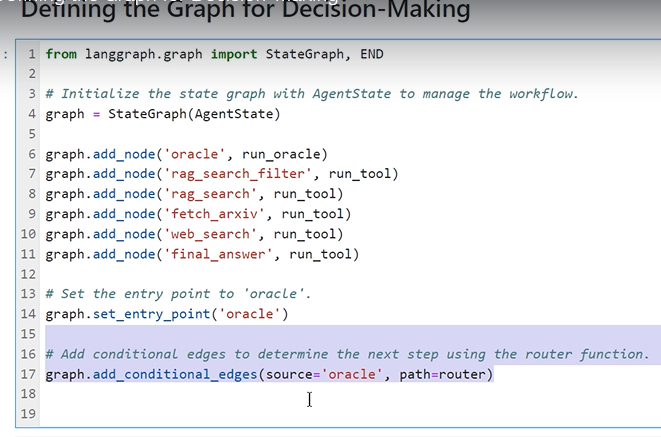

In [88]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

# Nodes
graph.add_node("oracle", run_oracle)

graph.add_node("rag_search", run_tool)
graph.add_node("rag_search_filter_pmc", run_tool)
graph.add_node("fetch_pmc_xml", run_tool)
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

# Entry
graph.set_entry_point("oracle")

# Oracle decides which tool to run next
graph.add_conditional_edges(
    "oracle",
    router,
    {
        "rag_search": "rag_search",
        "rag_search_filter_pmc": "rag_search_filter_pmc",
        "fetch_pmc_xml": "fetch_pmc_xml",
        "web_search": "web_search",
        "final_answer": "final_answer",
    },
)

# After each tool → go back to oracle
graph.add_edge("rag_search", "oracle")
graph.add_edge("rag_search_filter_pmc", "oracle")
graph.add_edge("fetch_pmc_xml", "oracle")
graph.add_edge("web_search", "oracle")

# Final answer ends the workflow
graph.add_edge("final_answer", END)

app = graph.compile()

In [93]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

print(app.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	oracle(oracle)
	rag_search(rag_search)
	rag_search_filter_pmc(rag_search_filter_pmc)
	fetch_pmc_xml(fetch_pmc_xml)
	web_search(web_search)
	final_answer(final_answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> oracle;
	fetch_pmc_xml --> oracle;
	oracle -.-> fetch_pmc_xml;
	oracle -.-> final_answer;
	oracle -.-> rag_search;
	oracle -.-> rag_search_filter_pmc;
	oracle -.-> web_search;
	rag_search --> oracle;
	rag_search_filter_pmc --> oracle;
	web_search --> oracle;
	final_answer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [95]:
from mermaid import Mermaid

mermaid_text = app.get_graph().draw_mermaid()
Mermaid(mermaid_text)


In [116]:
# Run the graph with input.
output = app.invoke({
    "input": "tell me something about PMC8728419?",
    "chat_history": [],
    "intermediate_steps": [],
})

print(output)

run_oracle
intermediate_steps: []


KeyError: 'fetch_pmc_abstract'

## 15. Building a Formatted Final Report

In [110]:
def build_report(output) -> str:
    # If final_answer returns a formatted string, just return it
    if isinstance(output, str):
        return output

    # Otherwise treat it as dict (teacher style)
    research_steps = output.get("research_steps", [])
    if isinstance(research_steps, list):
        research_steps = "\n".join([f"- {r}" for r in research_steps])
    else:
        research_steps = str(research_steps)

    sources = output.get("sources", [])
    if isinstance(sources, list):
        sources = "\n".join([f"- {s}" for s in sources])
    else:
        sources = str(sources)

    return f"""**Question:** {output.get("question","")}

INTRODUCTION

{output.get("introduction","")}

RESEARCH STEPS
{research_steps}

REPORT

{output.get("main_body","")}

CONCLUSION

{output.get("conclusion","")}

SOURCES
{sources}
"""




In [111]:
action, observation = output["intermediate_steps"][-1]  # observation is dict now
print(build_report(observation))



**Question:** mechanisms linking chronic inflammation to insulin resistance in metabolic syndrome

Chronic inflammation is a key factor in the development of insulin resistance, a hallmark of metabolic syndrome. Understanding the mechanisms that link these two conditions is crucial for developing effective treatments.

## Research steps
- Conducted a RAG search to find relevant scientific literature on the mechanisms linking chronic inflammation to insulin resistance in metabolic syndrome.
- Performed a web search to gather additional information from diverse sources.

## Main body
Chronic inflammation contributes to insulin resistance through several mechanisms. One primary pathway involves the production of pro-inflammatory cytokines, such as TNF-alpha and IL-6, which interfere with insulin signaling pathways. These cytokines can inhibit the insulin receptor substrate (IRS) and reduce the activity of phosphatidylinositol 3-kinase (PI3K), both of which are crucial for insulin action. 

In [121]:
from typing import TypedDict, Annotated, List, Tuple, Any
from langchain_core.messages import BaseMessage
from langchain_core.agents import AgentAction
import operator

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# -----------------------
# Agent state
# -----------------------
class AgentState(TypedDict):
    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[Tuple[AgentAction, Any]], operator.add]

# -----------------------
# LLM + prompt
# -----------------------
llm = ChatOpenAI(
    model="gpt-4o",
    api_key=os.environ["OPENAI_API_KEY"],
    temperature=0
)

system_prompt = """You are the oracle.
Choose exactly ONE tool to call next from the list of tools.

Rules:
- Don’t repeat the same tool with the same query.
- Don’t use any tool more than twice.
- When you have enough info, call final_answer.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}"),
    ("assistant", "scratchpad:\n{scratchpad}"),
])

# -----------------------
# Scratchpad
# -----------------------
def create_scratchpad(intermediate_steps: List[Tuple[AgentAction, Any]]) -> str:
    if not intermediate_steps:
        return ""
    parts = []
    for i, (action, obs) in enumerate(intermediate_steps, start=1):
        parts.append(
            f"Step {i}\n"
            f"Tool: {action.tool}\n"
            f"Input: {action.tool_input}\n"
            f"Output: {obs}\n"
        )
    return "\n---\n".join(parts)

# -----------------------
# Tools list
# IMPORTANT: these must exist in your notebook
# -----------------------
tools = [
    rag_search,
    rag_search_filter_pmc,
    fetch_pmc_xml,
    fetch_pmc_abstract,   # ✅ make sure this exists
    web_search,
    final_answer,
]

tool_str_to_func = {
    "rag_search": rag_search,
    "rag_search_filter_pmc": rag_search_filter_pmc,
    "fetch_pmc_xml": fetch_pmc_xml,
    "fetch_pmc_abstract": fetch_pmc_abstract,   # ✅ key fix
    "web_search": web_search,
    "final_answer": final_answer,
}

ALLOWED = set(tool_str_to_func.keys())

oracle_chain = (
    {
        "input": lambda s: s["input"],
        "chat_history": lambda s: s.get("chat_history", []),
        "scratchpad": lambda s: create_scratchpad(s.get("intermediate_steps", [])),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice="any")
)

# -----------------------
# Nodes
# -----------------------
def run_oracle(state: AgentState):
    out = oracle_chain.invoke(state)

    # If LLM did not call tools, force final_answer
    if not getattr(out, "tool_calls", None):
        action = AgentAction(tool="final_answer", tool_input={}, log="TBD")
        return {"intermediate_steps": [(action, "TBD")]}

    tc = out.tool_calls[0]
    tool_name = tc.get("name")
    tool_args = tc.get("args", {}) or {}

    # Safety: if tool name unknown → final_answer
    if tool_name not in ALLOWED:
        tool_name = "final_answer"
        tool_args = {
            "question": state["input"],
            "introduction": "Study/research report (not medical advice).",
            "research_steps": ["Oracle selected an unknown tool; forced final_answer."],
            "main_body": "No valid tool could be selected.",
            "conclusion": "Routing failed due to unknown tool selection.",
            "sources": [],
        }

    action = AgentAction(tool=tool_name, tool_input=tool_args, log="TBD")
    return {"intermediate_steps": [(action, "TBD")]}

def router(state: AgentState) -> str:
    last_action, _ = state["intermediate_steps"][-1]
    return last_action.tool if last_action.tool in ALLOWED else "final_answer"

def run_tool(state: AgentState):
    last_action, _ = state["intermediate_steps"][-1]
    tool_name = last_action.tool
    tool_args = last_action.tool_input or {}

    obs = tool_str_to_func[tool_name].invoke(tool_args)

    new_action = AgentAction(tool=tool_name, tool_input=tool_args, log=str(obs))
    return {"intermediate_steps": [(new_action, obs)]}

# -----------------------
# Graph (REBUILD + RECOMPILE)
# -----------------------
graph = StateGraph(AgentState)

graph.add_node("oracle", run_oracle)

graph.add_node("rag_search", run_tool)
graph.add_node("rag_search_filter_pmc", run_tool)
graph.add_node("fetch_pmc_xml", run_tool)
graph.add_node("fetch_pmc_abstract", run_tool)  # ✅ add node
graph.add_node("web_search", run_tool)
graph.add_node("final_answer", run_tool)

graph.set_entry_point("oracle")

# ✅ MUST include fetch_pmc_abstract in mapping
graph.add_conditional_edges(
    "oracle",
    router,
    {
        "rag_search": "rag_search",
        "rag_search_filter_pmc": "rag_search_filter_pmc",
        "fetch_pmc_xml": "fetch_pmc_xml",
        "fetch_pmc_abstract": "fetch_pmc_abstract",  # ✅ add mapping
        "web_search": "web_search",
        "final_answer": "final_answer",
    },
)

# tool → oracle loop
graph.add_edge("rag_search", "oracle")
graph.add_edge("rag_search_filter_pmc", "oracle")
graph.add_edge("fetch_pmc_xml", "oracle")
graph.add_edge("fetch_pmc_abstract", "oracle")  # ✅ loop back
graph.add_edge("web_search", "oracle")

graph.add_edge("final_answer", END)

# ✅ compile AFTER all nodes/edges exist
app = graph.compile()


In [122]:
from langchain_core.tools import tool
import requests, re, html, xml.etree.ElementTree as ET

@tool("fetch_pmc_abstract")
def fetch_pmc_abstract(pmcid: str) -> str:
    """Fetch abstract text for a PMCID (HTML first, XML fallback)."""
    pmcid = pmcid.strip()
    if not pmcid.upper().startswith("PMC"):
        pmcid = "PMC" + pmcid

    # 1) Try PMC HTML page
    url = f"https://pmc.ncbi.nlm.nih.gov/articles/{pmcid}/"
    res = requests.get(url, headers={"User-Agent": "DataDoc/1.0"}, timeout=30)
    res.raise_for_status()

    abstract_pattern = re.compile(
        r'<meta\s+name=["\']citation_abstract["\']\s+content=["\'](.*?)["\']\s*/?>',
        re.IGNORECASE | re.DOTALL
    )

    m = abstract_pattern.search(res.text)
    if m:
        return html.unescape(m.group(1)).strip()

    # 2) Fallback: EFetch XML
    pmc_numeric = pmcid.replace("PMC", "")
    efetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    params = {"db": "pmc", "id": pmc_numeric, "retmode": "xml"}
    r2 = requests.get(efetch_url, params=params, timeout=30)
    r2.raise_for_status()

    root = ET.fromstring(r2.text)
    parts = []
    for p in root.findall(".//abstract//p"):
        if p.text and p.text.strip():
            parts.append(p.text.strip())

    abstract = "\n".join(parts).strip()
    return abstract if abstract else "Abstract not found."


In [123]:
output = app.invoke({
    "input": "tell me something about PMC8728419?",
    "chat_history": [],
    "intermediate_steps": [],
})
print(output["intermediate_steps"][-1][1])   # observation


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT